## Introduction

This notebook is based off of a sample sagemaker notebook, using Kmeans clustering to identify groups of hand written numbers.

AWS-hosted notebook can be found here: https://dane-notebook.notebook.us-west-2.sagemaker.aws/notebooks/sample-notebooks/sagemaker-python-sdk/1P_kmeans_highlevel/K-means-clustering-DCH.ipynb#


## Prequisites and Preprocessing

### Setting up environment variables

In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='dane-bucket-1'

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training.  In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits.  For more details, please see [here](http://yann.lecun.com/exdb/mnist/).

This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 908 ms, sys: 276 ms, total: 1.18 s
Wall time: 2.96 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

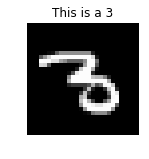

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Training the K-Means model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the k-means training algorithm.  But Amazon SageMaker's k-means has been tested on, and scales well with, multi-terabyte datasets.

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 7 and 11 minutes.

In [4]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

# training data will be uploaded to: s3://dane-bucket-1/kmeans_highlevel_example/data
# training artifacts will be uploaded to: s3://dane-bucket-1/kmeans_example/output

training data will be uploaded to: s3://dane-bucket-1/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://dane-bucket-1/kmeans_example/output


INFO:sagemaker:Created S3 bucket: sagemaker-us-west-2-613553399412


In [5]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-03-11-18-06-34-718


......................................................................
Docker entrypoint called with argument(s): train
[03/11/2018 18:12:19 INFO 139792706447168] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[03/11/2018 18:12:19 INFO 139792706447168] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'mini_batch_size': u'500', u'k': u'10', u'force_dense': u'True'}
[03/11/2018 18:12:19 INFO 13979270

===== Job Complete =====
CPU times: user 7.92 s, sys: 468 ms, total: 8.38 s
Wall time: 7min 53s


## Set up hosting for the model
Now, we can deploy the model we just trained behind a real-time hosted endpoint.  This next step can take, on average, 7 to 11 minutes to complete.

In [6]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-03-11-18-14-58-035
INFO:sagemaker:Creating endpoint with name kmeans-2018-03-11-18-06-34-718


-------------------------------------------------------------------------------------------------------------------------!CPU times: user 548 ms, sys: 16 ms, total: 564 ms
Wall time: 10min 29s


## Validate the model for use
Finally, we'll validate the model for use. Let's generate a classification for a single observation from the trained model using the endpoint we just created.

In [7]:
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 7.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 7.18982458114624
    }
  }
}
]


OK, a single prediction works.

Let's do a whole batch and see how well the clustering works.

In [8]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 274 ms





Cluster 0:


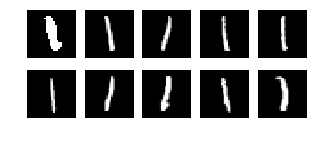




Cluster 1:


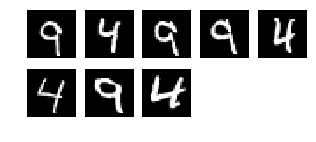




Cluster 2:


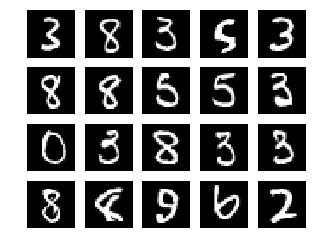




Cluster 3:


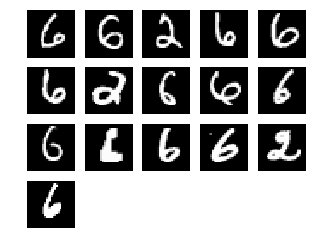




Cluster 4:


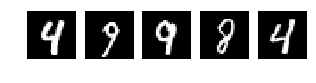




Cluster 5:


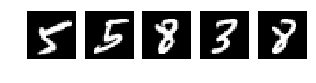




Cluster 6:


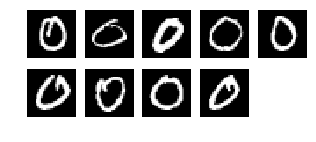




Cluster 7:


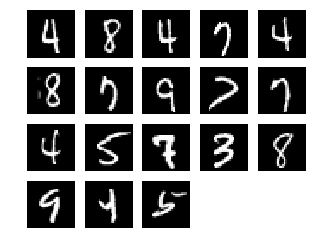




Cluster 8:


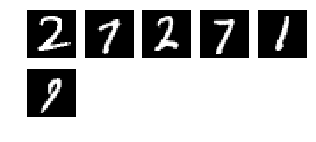




Cluster 9:


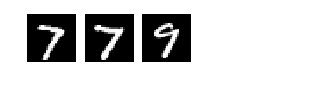

In [9]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

### The bottom line

K-Means clustering is not the best algorithm for image analysis problems, but we do see pretty reasonable clusters being built.

### (Optional) Delete the Endpoint
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
print(kmeans_predictor.endpoint)

In [ ]:
import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)